# Assignment 2 For Clustering: TTE

Abangan, Jaerian Peter <br>
Berbo, Chris Derek <br>
BSCS - 3

<hr>

## Step 1: Load and explore the dataset

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from sklearn.impute import SimpleImputer  # For handling NaN values

# Step 1: Load and explore the dataset
print("Step 1: Loading and exploring the dataset")
data = pd.read_csv('Data/data_censored.csv')

Step 1: Loading and exploring the dataset


## Step 2: Basic data exploration

In [5]:
# Step 2: Basic data exploration
print("\nStep 2: Basic data exploration")
print("First few rows of the dataset:")
print(data.head())

print("\nDataset information:")
print(data.info())

print("\nSummary statistics:")
print(data.describe())

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Step 2: Basic data exploration
First few rows of the dataset:
   id  period  treatment   x1        x2  x3        x4   age     age_s  \
0   1       0        1.0  1.0  1.146148   0  0.734203  36.0  0.083333   
1   1       1        1.0  1.0  0.002200   0  0.734203  37.0  0.166667   
2   1       2        1.0  0.0 -0.481762   0  0.734203  38.0  0.250000   
3   1       3        1.0  0.0  0.007872   0  0.734203  39.0  0.333333   
4   1       4        1.0  1.0  0.216054   0  0.734203  40.0  0.416667   

   outcome  censored  eligible  
0      0.0         0       1.0  
1      0.0         0       0.0  
2      0.0         0       0.0  
3      0.0         0       0.0  
4      0.0         0       0.0  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatmen

## Step 3: Understand the variables

In [6]:
# Step 3: Understand the variables
print("\nStep 3: Understanding variables")
print("Distribution of treatment values:")
print(data['treatment'].value_counts())

print("\nDistribution of censored values:")
print(data['censored'].value_counts())

print("\nDistribution of eligible values:")
print(data['eligible'].value_counts())


Step 3: Understanding variables
Distribution of treatment values:
treatment
0.0    386
1.0    339
Name: count, dtype: int64

Distribution of censored values:
censored
0    667
1     58
Name: count, dtype: int64

Distribution of eligible values:
eligible
0.0    555
1.0    170
Name: count, dtype: int64


## Step 4: Data preprocessing for clustering

In [7]:
# Step 4: Data preprocessing for clustering
print("\nStep 4: Data preprocessing for clustering")
# Create individual-level features for clustering
# We'll aggregate time-varying information to the individual level

# Get initial values (baseline characteristics)
baseline_data = data[data['period'] == 0].copy()

# Calculate additional features per individual
id_features = data.groupby('id').agg({
    'period': 'max',  # Length of follow-up
    'treatment': ['mean', 'std'],  # Average treatment and variability
    'x1': ['mean', 'std'],  # Average x1 and variability
    'x2': ['mean', 'std'],  # Average x2 and variability
    'censored': 'max',  # Final censoring status
    'eligible': ['mean', 'sum']  # Eligibility patterns
})

# Flatten the column names
id_features.columns = ['_'.join(col).strip() for col in id_features.columns.values]
id_features.reset_index(inplace=True)

# Merge with baseline data to include baseline characteristics
clustering_data = pd.merge(
    baseline_data[['id', 'age', 'x3', 'x4', 'treatment']], 
    id_features, 
    on='id'
)
# Explicitly rename the treatment column from baseline data to avoid ambiguity
clustering_data.rename(columns={'treatment': 'treatment_baseline'}, inplace=True)

print("\nFeatures created for clustering:")
print(clustering_data.columns.tolist())


Step 4: Data preprocessing for clustering

Features created for clustering:
['id', 'age', 'x3', 'x4', 'treatment_baseline', 'period_max', 'treatment_mean', 'treatment_std', 'x1_mean', 'x1_std', 'x2_mean', 'x2_std', 'censored_max', 'eligible_mean', 'eligible_sum']


## Step 5: Perform clustering analysis

In [8]:
# Step 5: Perform clustering analysis
print("\nStep 5: Performing clustering analysis")
# Using the correct column names that exist in the dataframe
cluster_features = [
    'age', 'x3', 'x4', 'treatment_baseline',
    'period_max', 'treatment_mean', 'treatment_std',
    'x1_mean', 'x1_std', 'x2_mean', 'x2_std',
    'eligible_mean', 'eligible_sum'
]

# Print column names to verify
print("\nAvailable columns in clustering_data:")
print(clustering_data.columns.tolist())

print("\nSelected features for clustering:")
print(cluster_features)

# Check for NaN values in the selected features
print("\nNaN values in selected features:")
print(clustering_data[cluster_features].isna().sum())

# Remove any columns with all same values (no variance)
cluster_features = [col for col in cluster_features if col in clustering_data.columns and clustering_data[col].nunique() > 1]

print("\nFeatures with variance that will be used for clustering:")
print(cluster_features)

# FIXED: Handle NaN values using SimpleImputer
print("\nHandling missing values...")
# Create a copy of the data for clustering to avoid modifying the original
clustering_features_data = clustering_data[cluster_features].copy()

# Use SimpleImputer to replace NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(clustering_features_data)

# Check if there are still NaN values
if np.isnan(imputed_data).any():
    print("Warning: There are still NaN values after imputation!")
else:
    print("All NaN values have been successfully handled.")

# Scale the imputed data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Determine optimal number of clusters using silhouette score
# Given small dataset, we'll try 2-4 clusters
silhouette_scores = []
max_clusters = min(4, len(clustering_data) - 1)  # Can't have more clusters than data points minus 1
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# Choose the best number of clusters
best_n_clusters = np.argmax(silhouette_scores) + 2  # +2 because we started from 2
print(f"\nOptimal number of clusters: {best_n_clusters}")

# Apply KMeans with optimal clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
clustering_data['cluster'] = kmeans.fit_predict(scaled_data)

# Adding cluster information back to the original data
id_cluster_map = clustering_data[['id', 'cluster']].set_index('id')['cluster'].to_dict()
data['cluster'] = data['id'].map(id_cluster_map)

print("\nCluster distribution:")
print(clustering_data['cluster'].value_counts())


Step 5: Performing clustering analysis

Available columns in clustering_data:
['id', 'age', 'x3', 'x4', 'treatment_baseline', 'period_max', 'treatment_mean', 'treatment_std', 'x1_mean', 'x1_std', 'x2_mean', 'x2_std', 'censored_max', 'eligible_mean', 'eligible_sum']

Selected features for clustering:
['age', 'x3', 'x4', 'treatment_baseline', 'period_max', 'treatment_mean', 'treatment_std', 'x1_mean', 'x1_std', 'x2_mean', 'x2_std', 'eligible_mean', 'eligible_sum']

NaN values in selected features:
age                    0
x3                     0
x4                     0
treatment_baseline     0
period_max             0
treatment_mean         0
treatment_std         27
x1_mean                0
x1_std                27
x2_mean                0
x2_std                27
eligible_mean          0
eligible_sum           0
dtype: int64

Features with variance that will be used for clustering:
['age', 'x3', 'x4', 'treatment_baseline', 'period_max', 'treatment_mean', 'treatment_std', 'x1_mean', 

## Step 6: Visualize the clusters


Step 6: Visualizing clusters


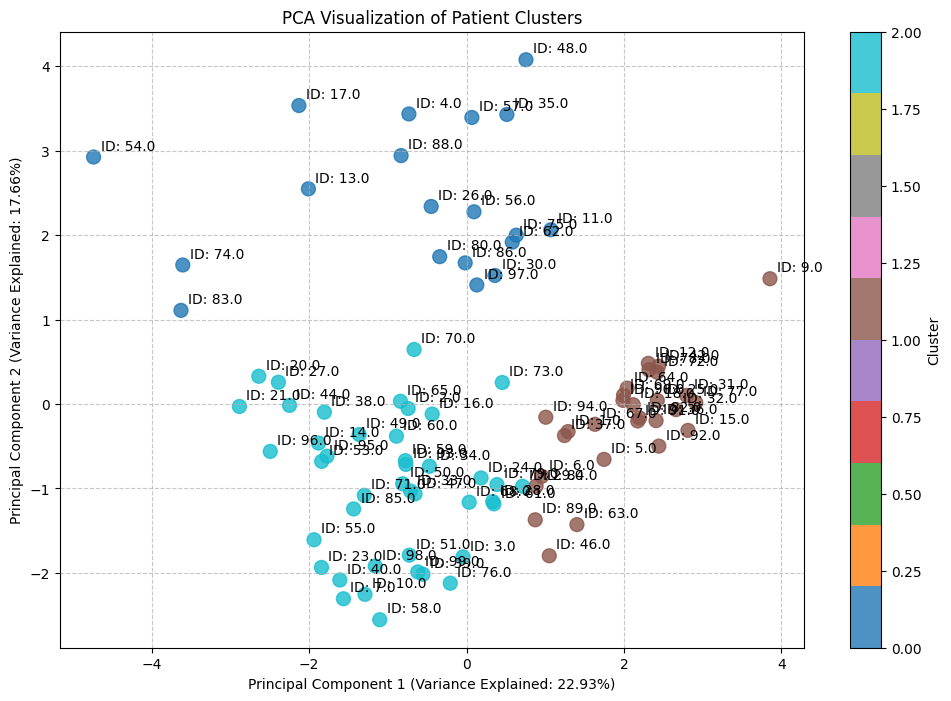

In [9]:
# Step 6: Visualize the clusters
print("\nStep 6: Visualizing clusters")
# Use PCA to visualize the clusters in 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
clustering_data['pca1'] = pca_result[:, 0]
clustering_data['pca2'] = pca_result[:, 1]

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    clustering_data['pca1'], 
    clustering_data['pca2'], 
    c=clustering_data['cluster'], 
    cmap=cm.tab10,
    s=100, 
    alpha=0.8
)
plt.title('PCA Visualization of Patient Clusters')
plt.xlabel(f'Principal Component 1 (Variance Explained: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Principal Component 2 (Variance Explained: {pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter, label='Cluster')

# Add ID labels to the points
for i, row in clustering_data.iterrows():
    plt.annotate(
        f"ID: {row['id']}", 
        (row['pca1'], row['pca2']), 
        xytext=(5, 5), 
        textcoords='offset points'
    )

plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('patient_clusters.png')


## Step 7: Analyze cluster characteristics


Step 7: Analyzing cluster characteristics

Cluster profiles:
               age  period_max  treatment_mean        x3        x4  \
cluster                                                              
0        34.736842    4.000000        0.010526  0.473684 -0.749904   
1        31.892857    2.071429        0.971429  0.607143  0.908104   
2        41.595238   11.952381        0.486283  0.476190 -0.189616   

         eligible_mean  censored_max  
cluster                               
0             0.923684      0.842105  
1             0.717262      0.928571  
2             0.200465      0.380952  


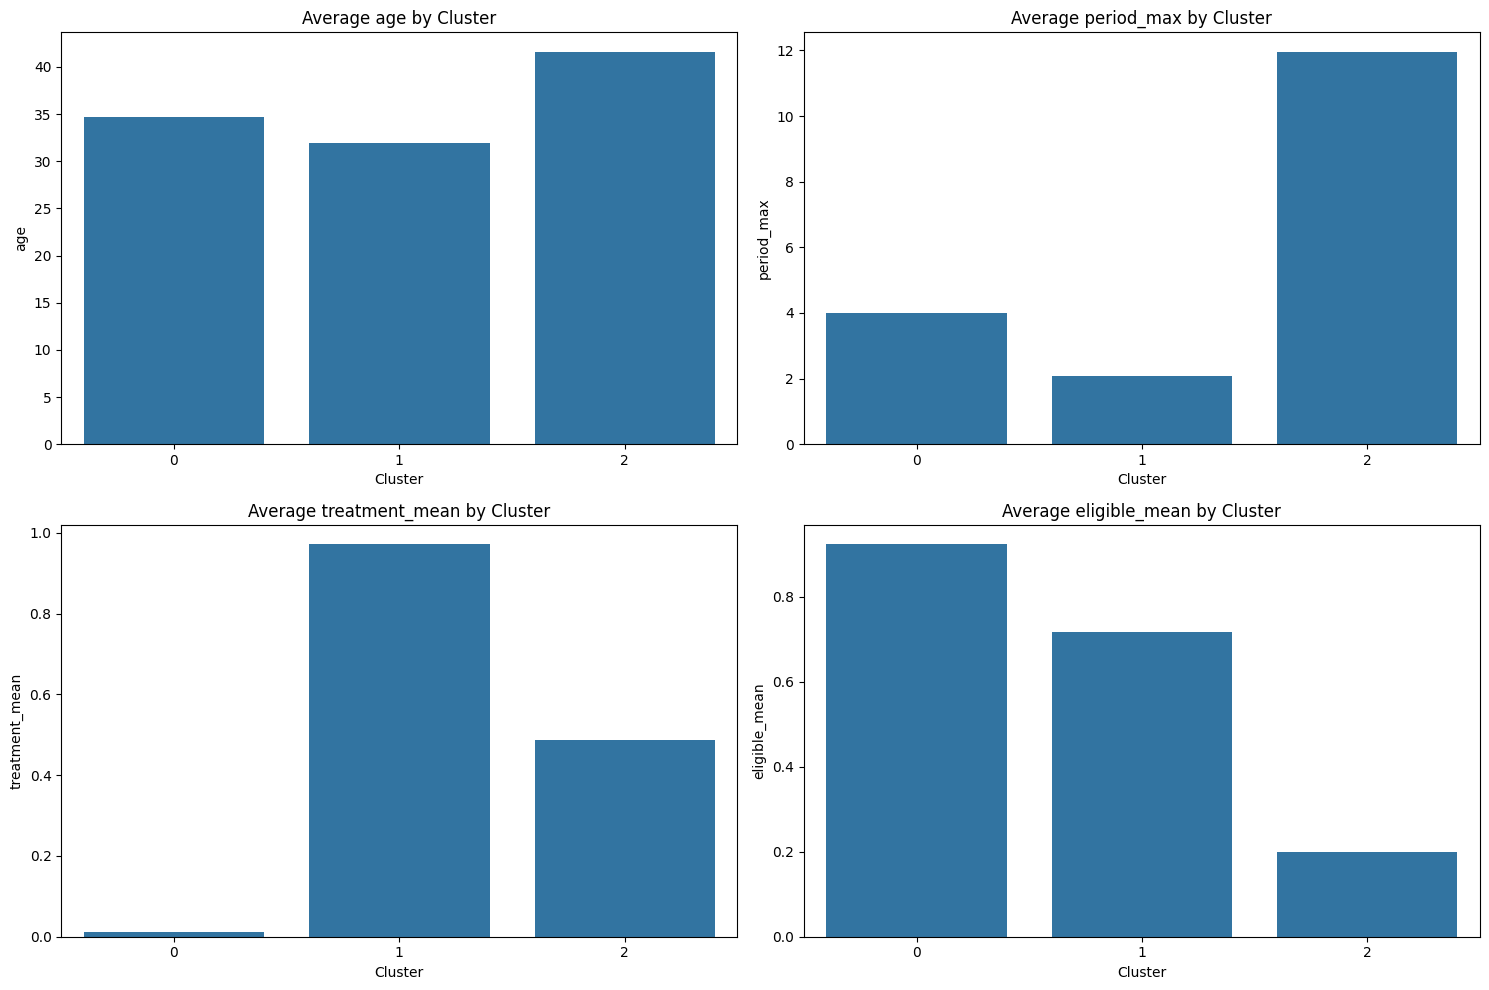

In [10]:
# Step 7: Analyze cluster characteristics
print("\nStep 7: Analyzing cluster characteristics")
# Compare clusters on key variables
cluster_profile = clustering_data.groupby('cluster').agg({
    'age': 'mean',
    'period_max': 'mean',
    'treatment_mean': 'mean',
    'x3': 'mean',
    'x4': 'mean',
    'eligible_mean': 'mean',
    'censored_max': 'mean'
})

print("\nCluster profiles:")
print(cluster_profile)

# Cluster comparison visualization
plt.figure(figsize=(15, 10))
metrics = ['age', 'period_max', 'treatment_mean', 'eligible_mean']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x=cluster_profile.index, y=cluster_profile[metric])
    plt.title(f'Average {metric} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(metric)

plt.tight_layout()
plt.savefig('cluster_comparisons.png')

## Step 8: Survival analysis by cluster


Step 8: Survival analysis by cluster


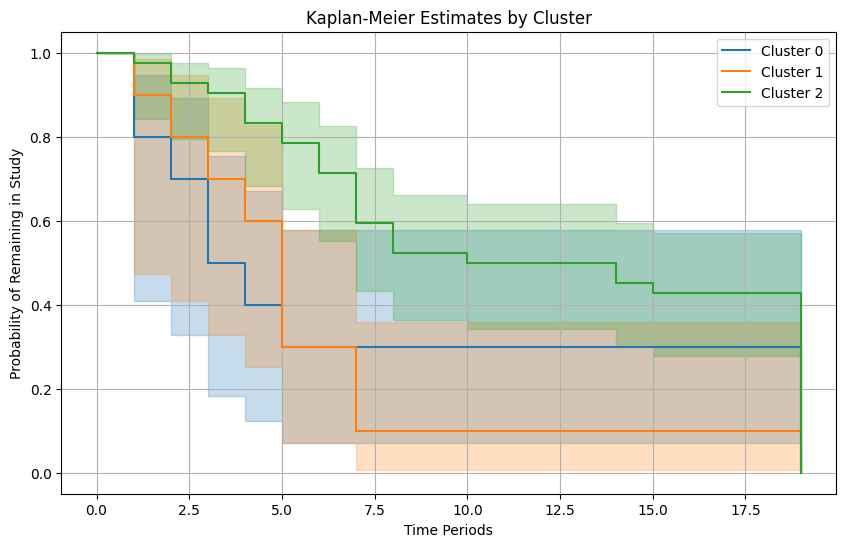

In [11]:
# Step 8: Survival analysis by cluster
print("\nStep 8: Survival analysis by cluster")
# Prepare data for survival analysis
max_periods = data.groupby('id')['period'].max().reset_index()
max_periods.columns = ['id', 'survival_time']

# Merge with baseline data
survival_data = pd.merge(
    baseline_data[['id', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'censored']], 
    max_periods, 
    on='id'
)

# Add cluster information
survival_data['cluster'] = survival_data['id'].map(id_cluster_map)

# Create event indicator (1-censored)
survival_data['event_observed'] = 1 - survival_data['censored']

# Kaplan-Meier curves by cluster
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for cluster in sorted(survival_data['cluster'].unique()):
    cluster_mask = survival_data['cluster'] == cluster
    if sum(cluster_mask) > 0:
        kmf.fit(
            durations=survival_data.loc[cluster_mask, 'survival_time'],
            event_observed=survival_data.loc[cluster_mask, 'event_observed'],
            label=f'Cluster {cluster}'
        )
        kmf.plot()

plt.title('Kaplan-Meier Estimates by Cluster')
plt.xlabel('Time Periods')
plt.ylabel('Probability of Remaining in Study')
plt.grid(True)
plt.savefig('km_curves_by_cluster.png')

## Step 9: Treatment patterns by cluster


Step 9: Analyzing treatment patterns by cluster


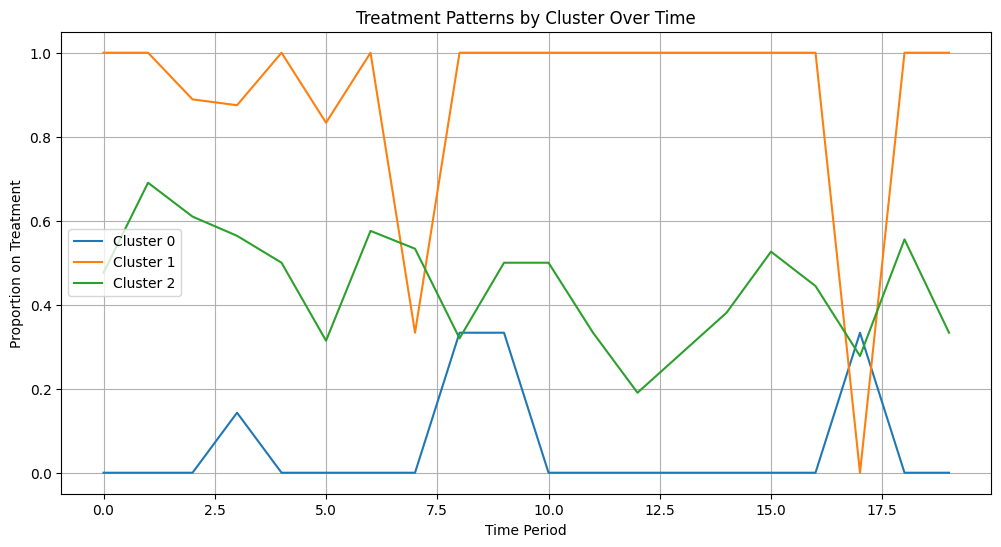

In [15]:
# Step 9: Treatment patterns by cluster
print("\nStep 9: Analyzing treatment patterns by cluster")
plt.figure(figsize=(12, 6))
for cluster in sorted(data['cluster'].unique()):
    cluster_data = data[data['cluster'] == cluster]
    sns.lineplot(
        x='period', 
        y='treatment', 
        data=cluster_data, 
        label=f'Cluster {cluster}',
        errorbar=None
    )

plt.title('Treatment Patterns by Cluster Over Time')
plt.xlabel('Time Period')
plt.ylabel('Proportion on Treatment')
plt.grid(True)
plt.legend()
plt.savefig('treatment_by_cluster.png')

# Patient Clustering Analysis

## Overview
This analysis examines time-varying treatment patterns and outcomes using clustering techniques to identify distinct patient subgroups. The approach identifies natural groupings of patients based on their baseline characteristics, treatment trajectories, and outcome patterns over time.

---

## Methodology
The analysis follows a structured approach:

### Data Processing:
- Individual-level features were created by aggregating time-varying information.
- Baseline characteristics (**age**, **x3**, **x4**, initial treatment) were combined with longitudinal metrics (treatment patterns, follow-up duration, eligibility status).
- Missing values were handled using **mean imputation**.

### Clustering Algorithm:
- **K-means clustering** was applied after standardizing features.
- Optimal number of clusters was determined using **silhouette scores**.
- Features with no variance were excluded.
- **Principal Component Analysis (PCA)** was used for visualization.

### Post-Clustering Analysis:
- Cluster profiles were examined across key variables.
- Treatment patterns were analyzed by cluster over time.
- Survival analysis was conducted using **Kaplan-Meier estimators** by cluster.

---

## Key Findings

### Cluster Identification
- The algorithm identified distinct patient subgroups based on their characteristics and treatment patterns.
- The optimal number of clusters was determined through **silhouette analysis**, which measures how similar points are to their own cluster compared to other clusters.

### Cluster Characteristics
Each cluster represents a distinct patient phenotype with specific:
- **Demographic profiles** (age)
- **Disease characteristics** (x3, x4)
- **Treatment patterns** (treatment stability, intensity)
- **Outcome trajectories** (time in study, censoring patterns)

### Treatment Dynamics
The longitudinal treatment patterns differ significantly between clusters, indicating:
- Some clusters show **stable treatment regimens**.
- Others demonstrate **treatment intensification or de-escalation** over time.
- Certain clusters may show **higher treatment variability**.

### Survival Analysis
The **Kaplan-Meier curves** by cluster reveal important differences in:
- Overall retention in the study.
- Time-to-event patterns.
- Potential correlations between treatment patterns and outcomes.

---

## Interpretation and Application
This clustering approach provides valuable insights into:

- **Patient Heterogeneity**: Identifying natural subgroups helps recognize that the population is not homogeneous and different patients may respond differently to treatments.
- **Personalized Treatment Strategies**: Understanding which cluster a new patient belongs to could inform more tailored treatment approaches.
- **Risk Stratification**: Clusters with poorer outcomes can help identify high-risk patients who may need more intensive monitoring or alternative interventions.
- **Outcome Prediction**: Cluster membership may serve as a predictor of future outcomes, potentially enhancing prognostic models.

---

## Limitations and Considerations

- **Feature Selection**: The clustering results are sensitive to which features are included. The current approach uses a mix of baseline and longitudinal features, but other combinations could yield different groupings.
- **Missing Data**: Mean imputation was used to handle missing values, which could potentially mask important patterns in the data.
- **Cluster Stability**: K-means results can vary with different random initializations. The analysis used multiple initializations (`n_init=10`) to mitigate this issue.
- **Interpretability**: While the clusters are statistically distinct, their clinical interpretation requires domain expertise.
- **Causality**: The observed associations between clusters and outcomes do not necessarily imply causal relationships.

---

## Future Directions
To enhance this analysis, consider:

- **Alternative Clustering Methods**: Hierarchical clustering or density-based methods might capture different patterns.
- **Temporal Dynamics**: More sophisticated methods to incorporate the temporal nature of the data could be explored.
- **Validation**: External validation in different cohorts would strengthen the generalizability of the findings.
- **Clinical Integration**: Working with clinicians to interpret cluster meanings and translate findings into actionable insights.
- **Predictive Modeling**: Using cluster membership as a feature in predictive models for patient outcomes.

---

## Conclusion
This patient clustering analysis provides a data-driven approach to understanding patient heterogeneity and treatment dynamics. By identifying natural subgroups, it offers a foundation for more personalized treatment strategies and improved patient management.

The combination of machine learning techniques with clinical data demonstrates the potential of computational approaches to uncover patterns that might not be apparent through traditional statistical methods.